# Homework for Smarties 2024
### Name: Kartik VISWANATHAN
### MSD 2024

## Introduction
The notation below are the same as on the slides. The topic is study of a test for the
mean function. More precisely, you have to compute a test statistic like
$$
Tnorm,N := N∥̂\hat{\mu} − \mu∥2
$$
(where $\hat{\mu}$ is some estimator of the mean function) and investigate its behavior :
under the null hypothesis $H_0 : \mu = \mu_{0}$ for some given mean function $\mu_{0}$ (e.g., the null function);
under alternatives (departures from the null).
The test size is denoted α. Using simulated data, you investigate the accuracy of the level $α$, and the
power of the test. The data have to be generated using the computer, but mimicking real data features:
the curves observed with error, on a random design set with only few points.

## Purpose
The test using $T_{norm},N$, presented in the lectures with ̂$\hat{\mu}$ the empirical mean function, is
based on asymptotic arguments and is designed for the ideal case where the curves are observed everywhere
without error. The purpose of this homework is to evaluate the consequences of applying this test with
data which are not like in the theory.

In [15]:
import numpy as np
from matplotlib import pyplot as plt

Now we generate the X(t) based on the Karhunen-Loève expansion for Brownian motion

In [16]:
def FDA_generator(N, K, J, noise_var, mu0_func=None, mu_func=None, plot=False, gamma=None):

    #Parameters
    #K = 100 #number of domain points
    #N = 100 #number of curves

    #Create a random set of domain points. These are usually fixed for all the curves
    t = np.random.uniform(0, 1, K)

    #KL brownian motion
    #J = 10 #KL truncation at J terms

    #create lmda (eigenvalues) phi(t) (eigenfunctions)
    lmda = [1 / ((j-0.5)**2 * np.pi**2) for j in range(1,J+1)]
    phi = [np.sqrt(2)*np.sin(j*np.pi*t) for j in range(1,J+1)]


    #epsilon noise variance
    #noise_var = [0, 0.5, 1.0, 2.0]

    # Define a mean function mu(t) (for example, a simple linear mean function)
    if mu0_func == "sin":
        mu_0 = np.sin(2 * np.pi * t)
    else:
        mu_0 = np.zeros(K)

    if mu_func == "sin":
        mu = np.sin(2 * np.pi * t)
    elif mu_func == "cosine":
        mu = np.cos(2 * np.pi * t)
    else:
        mu = np.zeros(K)

    if gamma:
        mu = gamma*mu_0 + (1-gamma)*mu
    


    for var in noise_var:
        X = np.zeros((N, K))  # Reset curves for each noise variance
        Y = np.zeros((N,K))
        t_sorted = np.zeros((N, K))
        X_sorted = np.zeros((N, K))
        Y_sorted = np.zeros((N, K))
        # Adjust figure size to make the plot wider
        if plot:
            plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
        for i in range(N):
            X[i] = mu.copy()  # Set the mean function as the initial value of the curve
            for j in range(J):
                X[i] += np.random.normal(0, np.sqrt(lmda[j]), K) * phi[j] # xi * phi where xi ~ N(0, lmda)

            #Add noise
            Y[i] = X[i].copy()
            Y[i] += np.random.normal(0, np.sqrt(var), K) #epsilon noise

            # Sort the domain points t and corresponding X and Y values
            sorted_indices = np.argsort(t)  # Get sorted indices of t
            t_sorted[i] = t[sorted_indices]    # Sorted domain points
            X_sorted[i] = X[i][sorted_indices] # Corresponding X values sorted by t
            Y_sorted[i] = Y[i][sorted_indices] # Corresponding Y values sorted by t

            
            
            #Plot
            if plot:
                if (i+1) % 30 != 0:  # Limit the number of curves to plot for better visualization
                    continue
                plt.plot(t_sorted[i], X_sorted[i], linewidth=0.5, label=f"X{i+1}")
                plt.scatter(t_sorted[i], Y_sorted[i], s=10, marker='o', label=f"Y{i+1}")

        #Store the t_sorted, X_sorted and Y_sorted values for each noise variance
        np.savetxt(f"t_sorted_{var}.csv", t_sorted, delimiter=",")
        np.savetxt(f"X_sorted_{var}.csv", X_sorted, delimiter=",")
        np.savetxt(f"Y_sorted_{var}.csv", Y_sorted, delimiter=",")

    
        # Plot
        if plot:
            plt.xlabel("t")
            plt.ylabel("X(t)")
            plt.title(f"Effect of Noise Variance={var} on X(t)")
            plt.legend()
            plt.show()



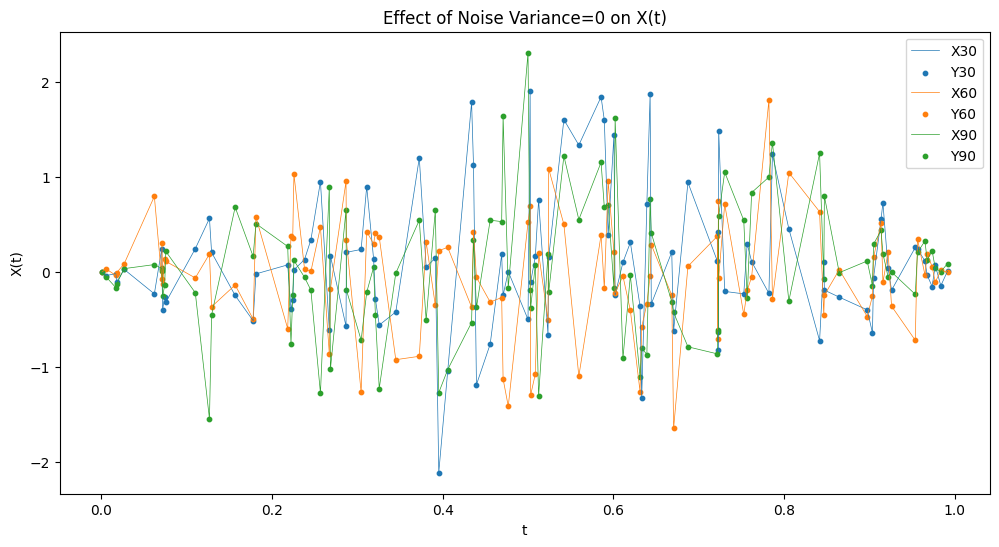

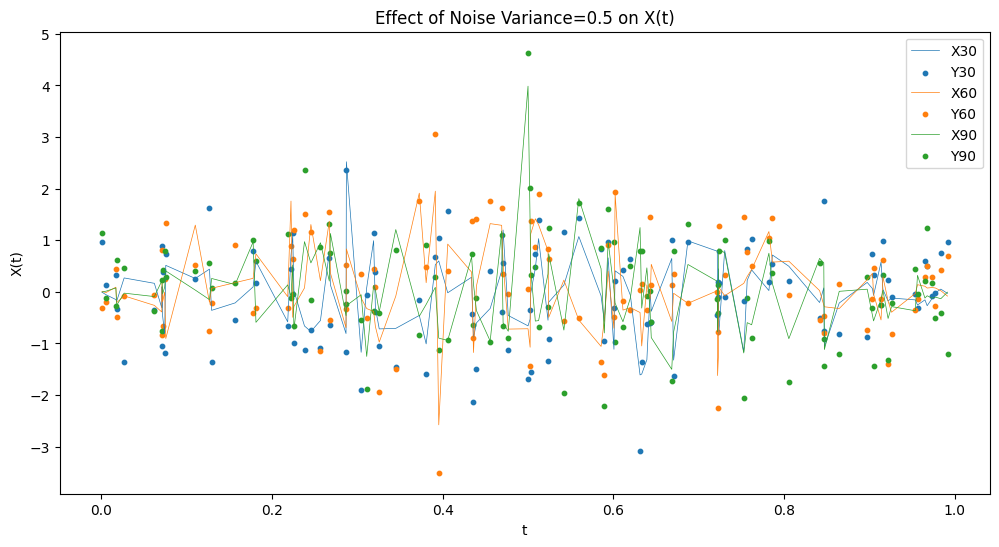

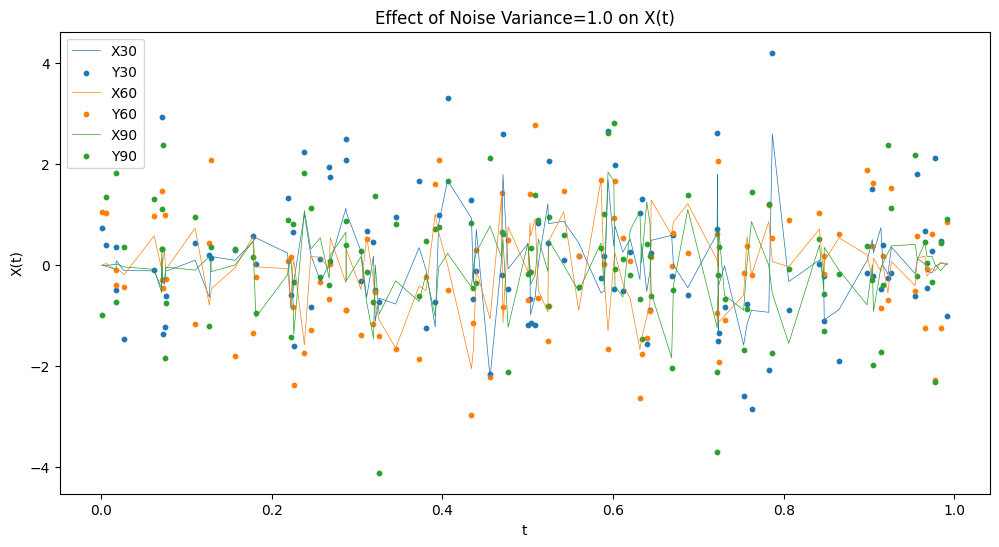

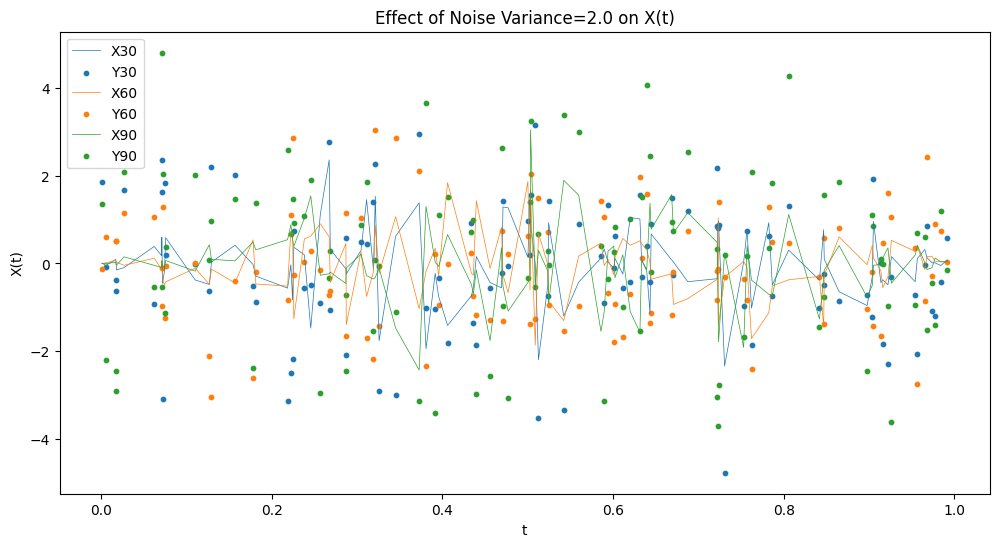

In [17]:
FDA_generator(100, 100, 10, [0, 0.5, 1.0, 2.0], plot=True)

## Curves reconstruction


In theory, the curves have to be reconstructed for each $t$ ∈ [0,1], and next
averaged to get the mean function estimator. In practice, is not possible to reconstruct the curves $X_i$ in
any point $t$, a refined grid of points will be used instead.

Consider some (large) L, and an equidistant grid of L+ 1 points on [0,1], that is tl = l/L, 0 ≤l ≤L.
For each i, you have to compute $\hat{X_i(t_l)}$ that are estimates of $X_i(t_l)$, for all $t_0,t_1,\dots,t_L$. Two types
of estimates will be asked :

– estimate the $X_i(t_l)$’s by linearly interpolating the $Y_{ik}$;

– estimate the $X_i(t_l)$’s by smoothing, either kernel smoothing (Nadaraya-Watson) or splines

In [18]:
#TODO: Implement Nadaraya-Watson Kernel Regression

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

def curve_approximation(interpolation_kind, noise_var, L, N, plot=False):
    # construct the tl grid
    #L = 200

    for var in noise_var:
        t_sorted = np.loadtxt(f"t_sorted_{var}.csv", delimiter=",")
        X_sorted = np.loadtxt(f"X_sorted_{var}.csv", delimiter=",")
        Y_sorted = np.loadtxt(f"Y_sorted_{var}.csv", delimiter=",")
        X_hat_tl = np.zeros((N, L))
        if plot:
            plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
        for i in range(N):
            t_min = np.min(t_sorted[i])
            t_max = np.max(t_sorted[i])

            # Ensure tl is within the range of t_sorted[i]
            tl = np.linspace(t_min, t_max, L)

            if interpolation_kind != "CubicSpline":
                interpolator = interp1d(t_sorted[i], Y_sorted[i], kind=interpolation_kind)
            else:
                interpolator = CubicSpline(t_sorted[i], Y_sorted[i], bc_type='natural')  # 'natural' for natural boundary conditions
            X_hat_tl[i] = interpolator(tl)

            #Plot
            if plot:
                if (i+1) % 90 == 0:
                    plt.plot(t_sorted[i], X_sorted[i], linestyle='--', linewidth=0.5, label=f"X{i+1}")
                    plt.scatter(t_sorted[i], Y_sorted[i], s=10, marker='o', label=f"Y{i+1}")
                    plt.plot(tl, X_hat_tl[i], linewidth=0.5, label=f"X_hat{i+1}")

        #Store the X_hat_tl values for each noise variance
        np.savetxt(f"X_hat_tl_{var}_{interpolation_kind}.csv", X_hat_tl, delimiter=",")
        
        if plot:
            plt.xlabel("t")
            plt.ylabel("X(t)")
            plt.title(f"{interpolation_kind} interpolation with Noise Variance={var} on X(t)")
            plt.legend()
            

    

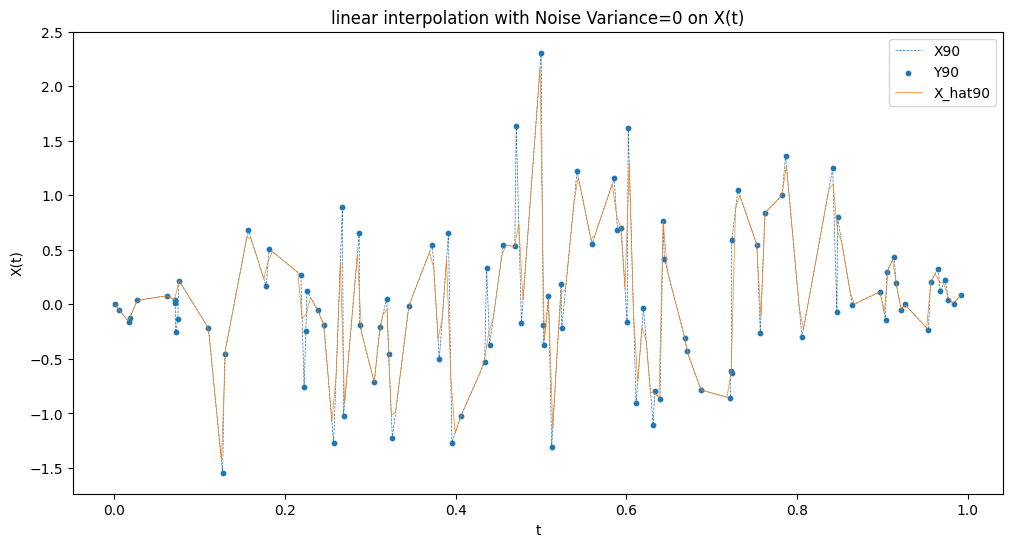

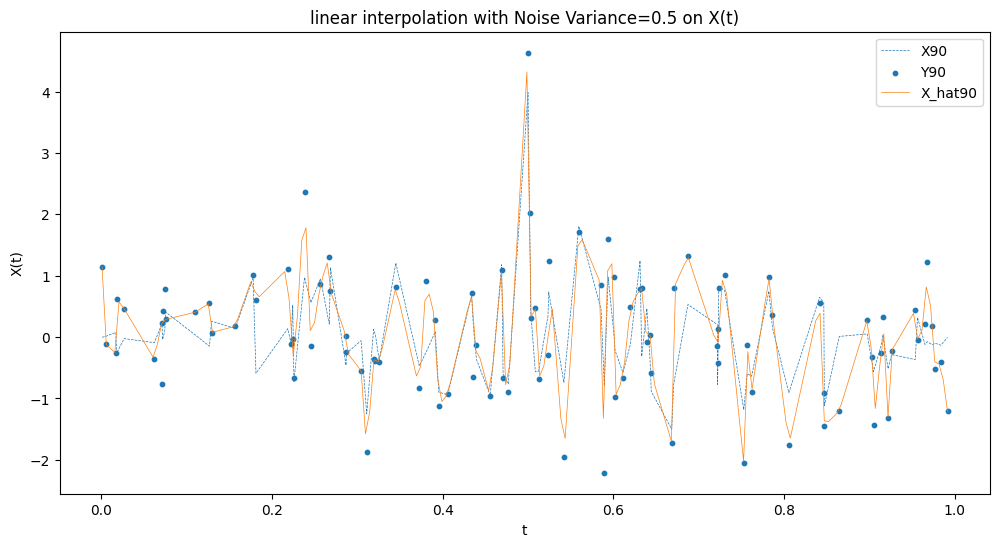

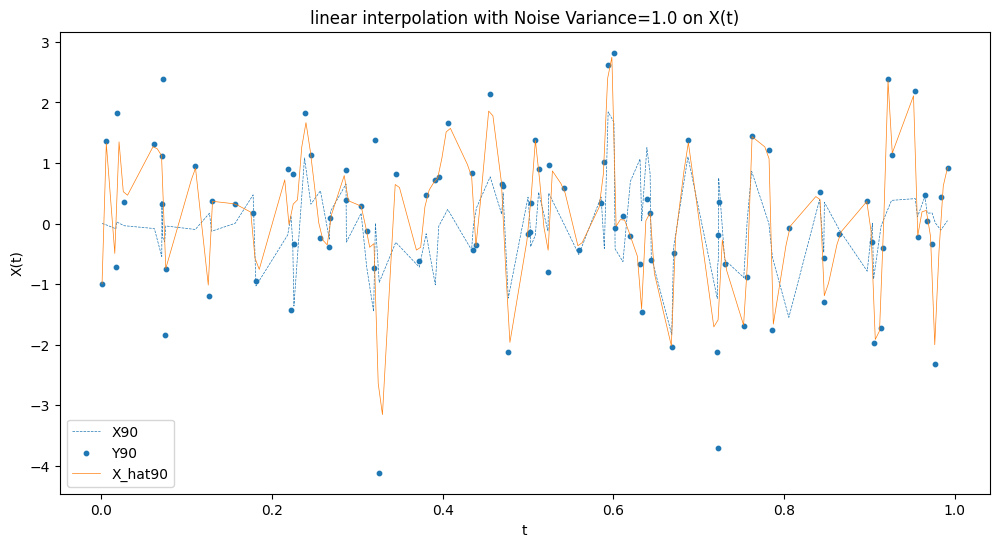

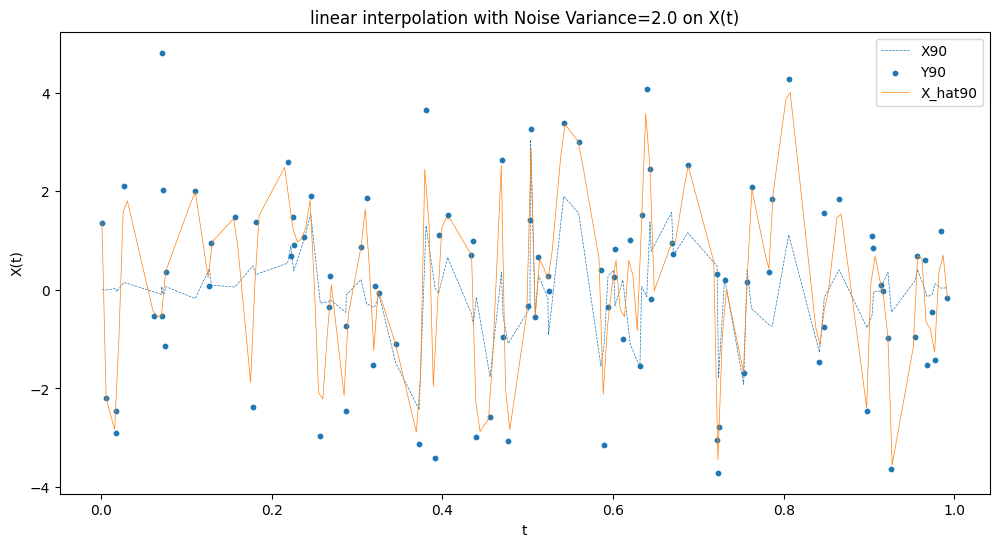

In [19]:
curve_approximation("linear", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

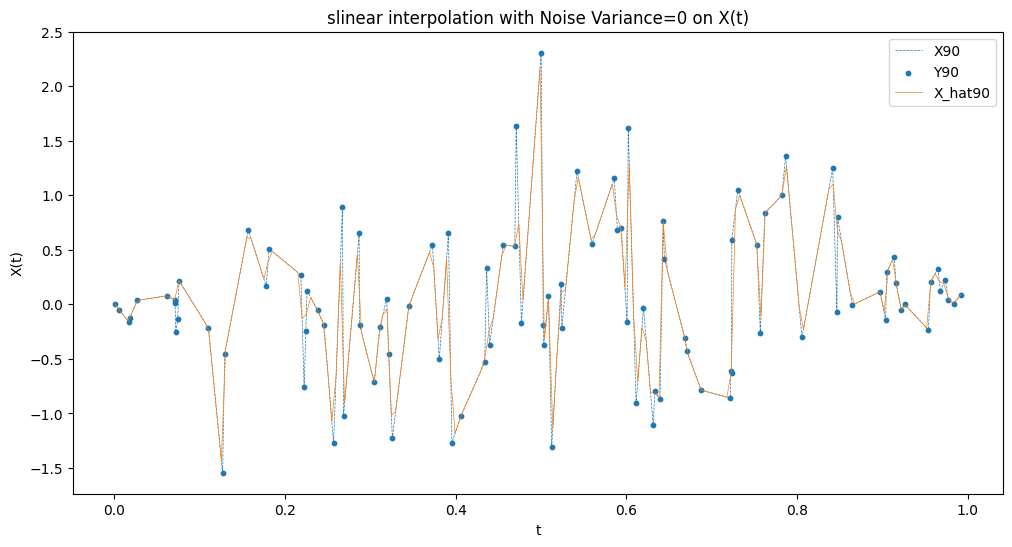

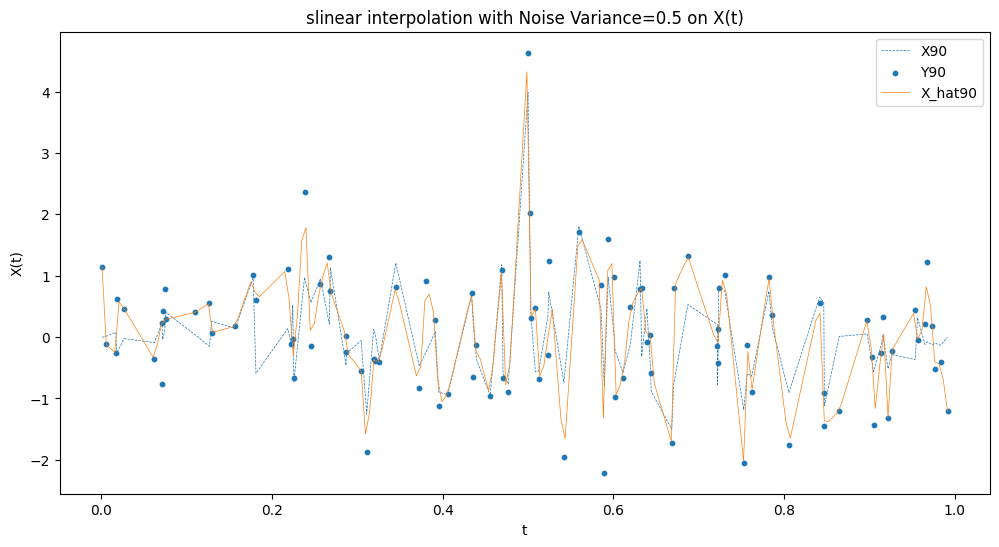

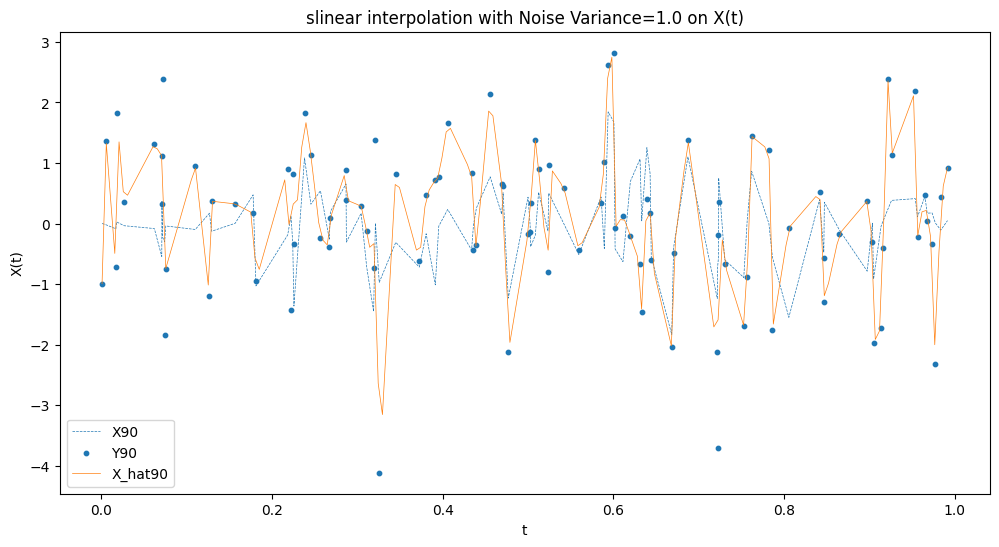

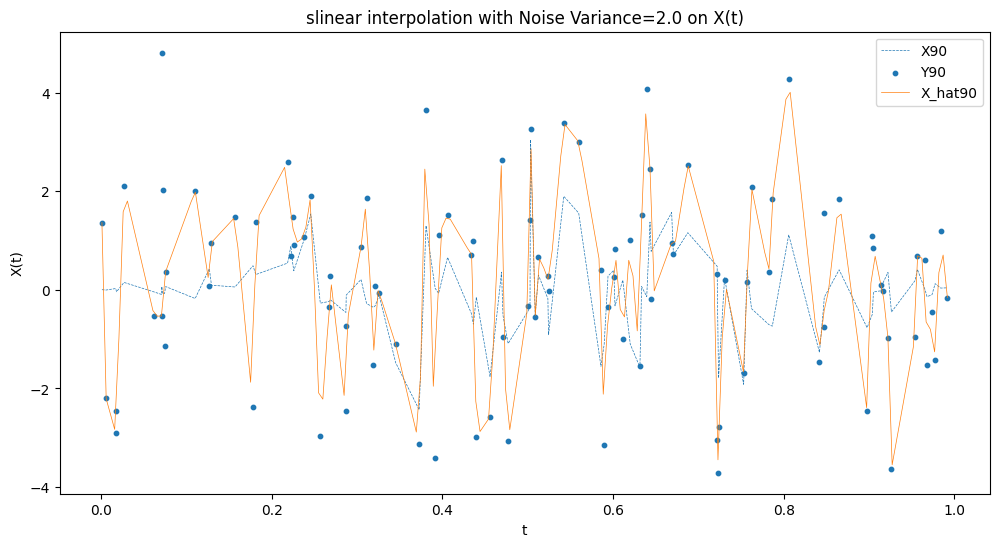

In [20]:
curve_approximation("slinear", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

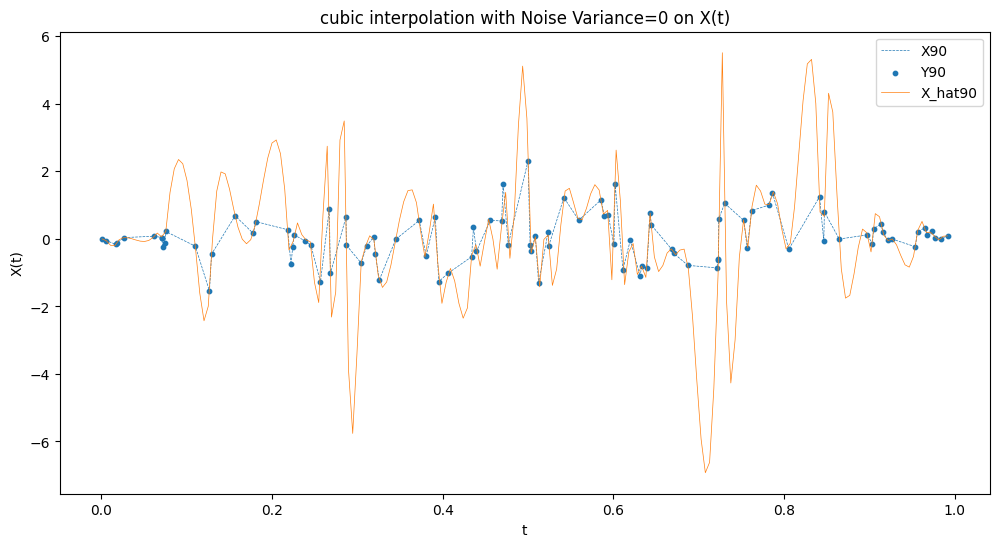

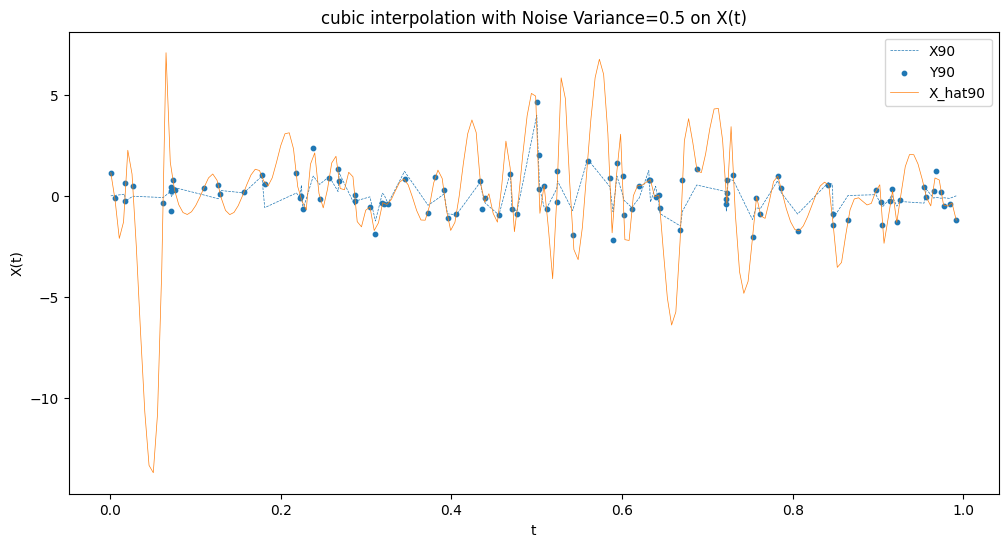

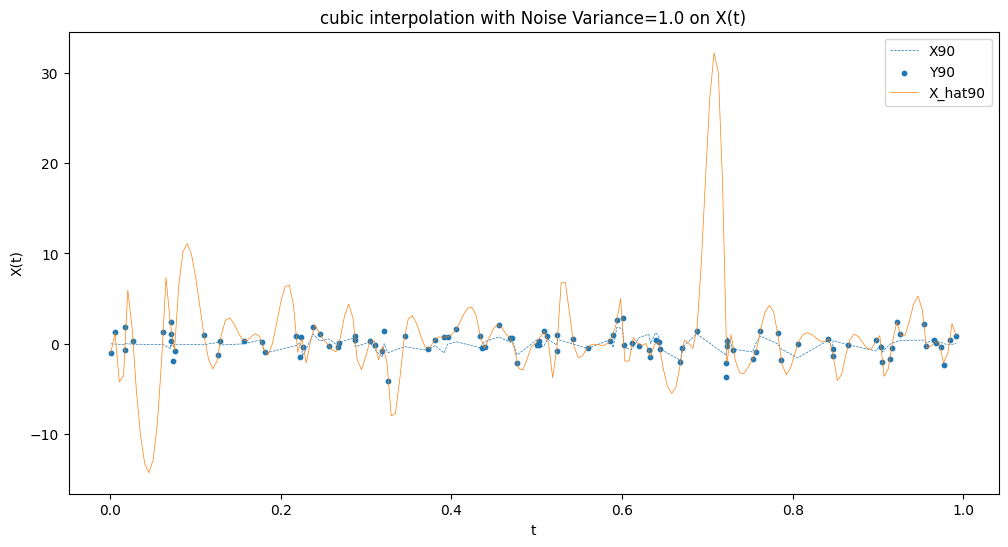

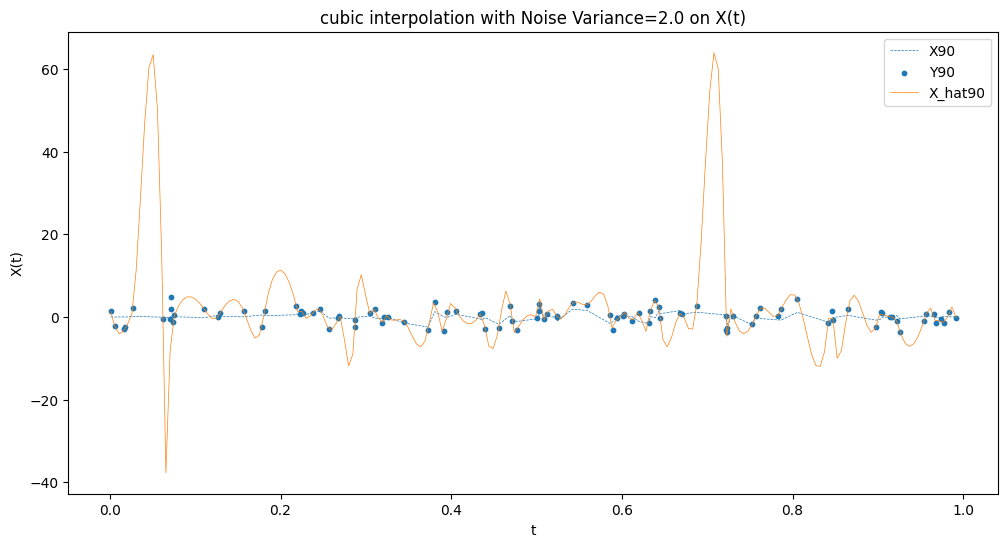

In [21]:
curve_approximation("cubic", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

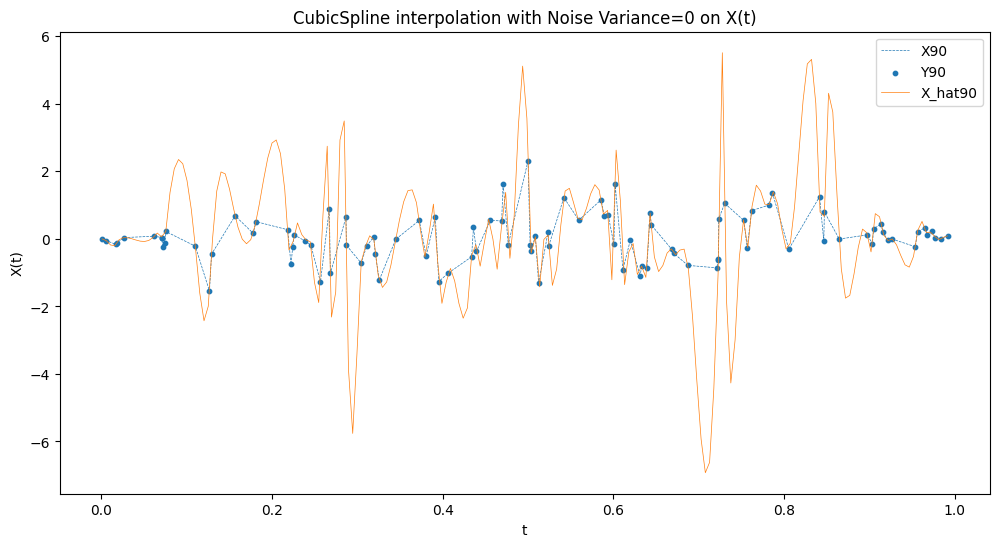

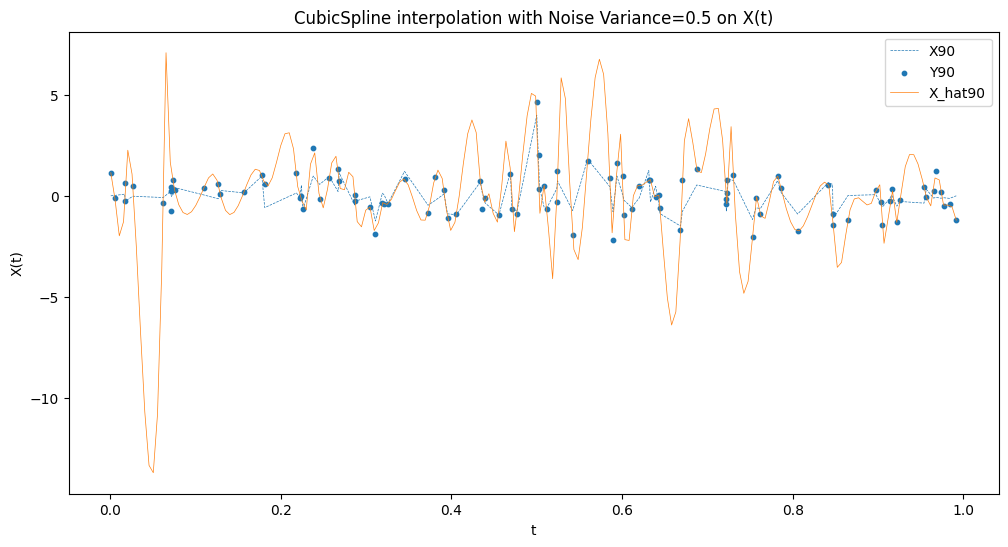

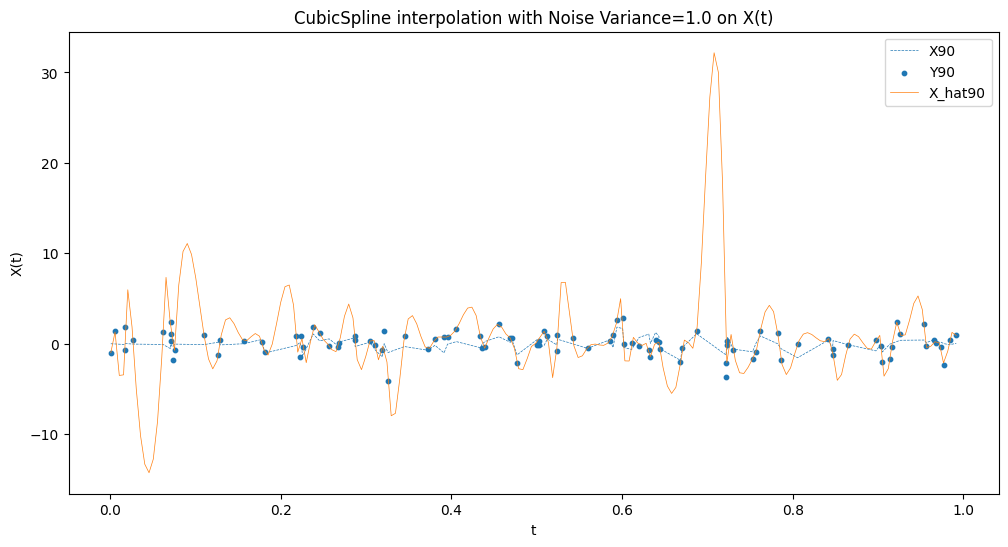

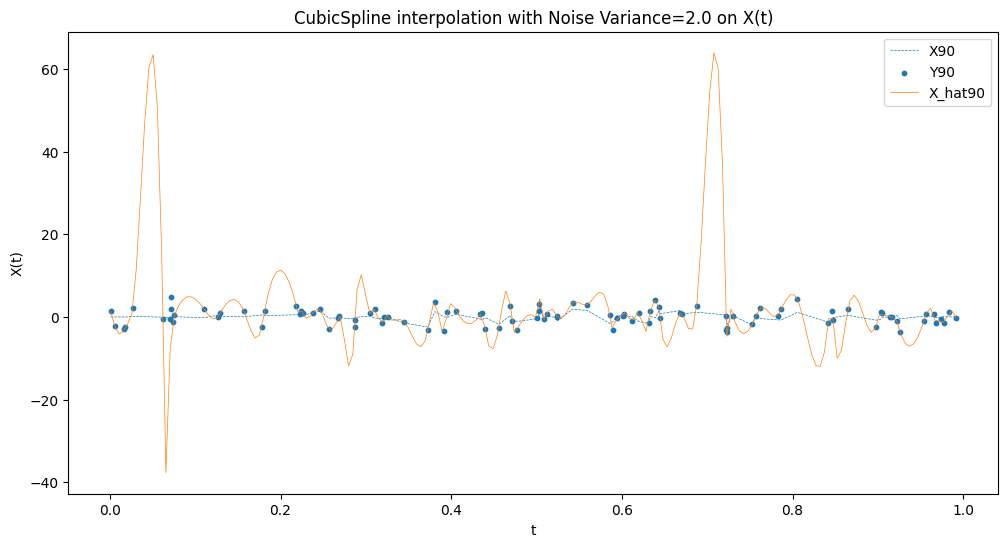

In [22]:
curve_approximation("CubicSpline", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

### Conclusion for Curve Estimation
From the results above, it is clearly seen that curve estimation techniques using interpolation (linear, cubic, spline etc.) do not approximate the $X$ values correctly. Some other methods need to employed to do such approximations. Kernel smoothning techniques like Nadaraya-Watson or Linear Local Regression can be used for better results.

## Computing the test statistic

### Estimating the empirical mean of $\hat{X_i}$
The mean 
$$
\hat{\mu}(t_l) = \frac{1}{N}\sum_{i=1}^N \hat{X}(t_l) , l=0,1,\dots,L
$$
We consider the cubic spline interpolated $\hat{X}(t_l)$ for estimating the empirical mean.

$T_{norm}$ is approximated using the trapezoidal rule.

In [23]:
from scipy.integrate import trapezoid
#calculate mu_hat and mu_0
def calculate_means_Tstats(L, N, noise_var, interpolation_kind=None, mu0_func=None, plot=False):
    #expected mu function
    t = np.linspace(0, 1, L)
    if mu0_func == "sin":
        mu_0 = np.sin(2 * np.pi * t)  # Example mean function
    else:
        mu_0 = np.zeros(L)
    if plot:
        plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
    #load the X_hat_tl values for each noise variance
    for var in noise_var:
        X_hat_tl = np.loadtxt(f"X_hat_tl_{var}_{interpolation_kind}.csv", delimiter=",")
        mu_hat = np.mean(X_hat_tl, axis=0)
        if plot:
            plt.plot(t, mu_hat, label=f"mu_hat_{var}")
        #Compute the Tstatistic
        difference = (mu_hat - mu_0) ** 2
        Tnorm_N = float(trapezoid(difference, t) * N)
        if plot:   
            print(f"Tnorm_N for noise variance={var} is {Tnorm_N}")
        else:
            return Tnorm_N
    
    if plot:
        plt.plot(t, mu_0, label="Expected mean function", linestyle='--', linewidth=2, color='black')
        plt.xlabel("t")
        plt.ylabel("mu(t)")
        plt.title(f"Mean Function Estimation using {interpolation_kind} Interpolation")
        plt.legend()
        plt.show()


Tnorm_N for noise variance=0 is 12.98347756804408
Tnorm_N for noise variance=0.5 is 22.76093812025576
Tnorm_N for noise variance=1.0 is 30.675824639796435
Tnorm_N for noise variance=2.0 is 52.00420036368438


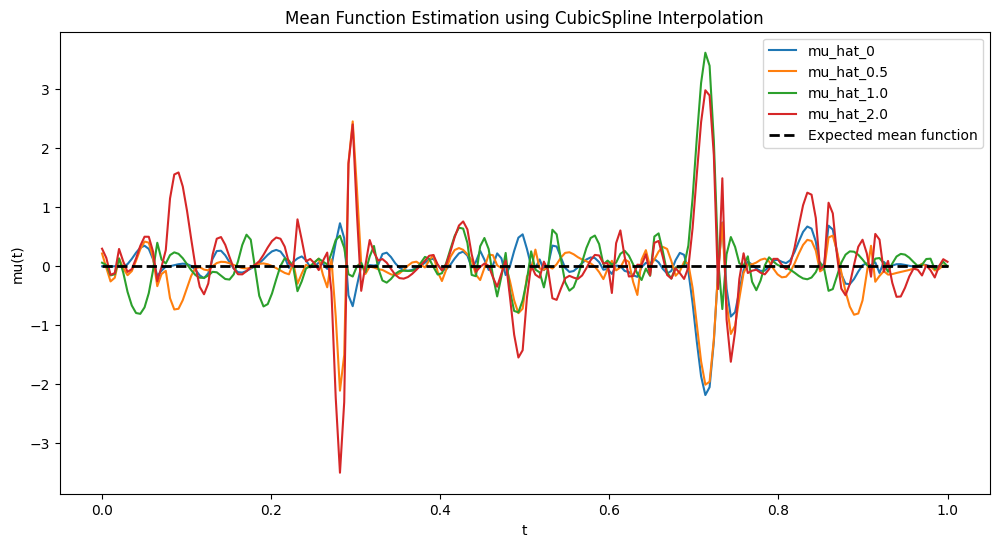

In [24]:
calculate_means_Tstats(200, 100,  [0, 0.5, 1.0, 2.0], "CubicSpline", mu0_func=None, plot=True)


### Conclusion
The estimated mean values of the curves interpolated using cubic spline interpolation, based on the different variances  in the noise, show that they are quite far away from the expected mean.

The $T_{norm,N}$ values show interesting results. For noise variance = 0, we see that the $T_{norm,N} \approx 36$ but it reduces on adding a noise with variance $0.5$ to $T_{norm,N} \approx 15$. The added noise somehow is reducing the signal to nose ratio to get a better $T_{norm,N}$ value. The other 2 noise added data show poor $T_{norm,N}$ values.  
These values need to be analysed over several runs to see whether the T-scores are consistent and compared to the ideal T-score. This is done in the next section.

## Compute critical values of the test

Here we are computing the $T_{norm,N}$ values using a Monte-Carlo simulation of $R = 1000$ iterations. The T-test value i.e $T_{norm,N} = N|\hat{\mu}-\mu|^{2}$ for the difference between the empirical mean function of $X_i$ and the expected mean function of X, is given by
$$
T_{norm,N} = N|\hat{\mu}-\mu|^{2} = \sum_{J \geq 1} \lambda{j}\Z_{j}
$$
where, $\lambda_{j}$ is the eigenvalues of the covariance operator of $X$ and $Z$ is a random vector that follows the chi-squared $\chi^2$ distribution. The $\chi^2$ random vector contains $M = 250$ i.i.ds with $N = 100$ degrees of freedom. The sum of the $Z$ over $j$ is another $\chi^2$ distribution.  
We then compute the quantile value at the given $\alpha = 0.05$

In [25]:
 #create lmda (eigenvalues) phi(t) (eigenfunctions)
N = 100 #number of curves
M = 250 #KL truncation at M terms
alpha = 0.05
R = 1000 #number of simulations

lmda = np.array([1 / ((j-0.5)**2 * np.pi**2) for j in range(1,M+1)])

Tnorm_M = []
for _ in range(R):
    #create Z random variable from chi-squared distribution
    Z = np.random.chisquare(N, M)
    #Compute the Tstatistic
    Tnorm_M.append(np.sum(lmda*Z)) 
    
Tnorm_M = np.array(Tnorm_M)
#calculate the quantiles
quantile_Tnorm = np.quantile(Tnorm_M, 1-alpha)

print(f"Quantile for alpha=1-{alpha} is {quantile_Tnorm}")

Quantile for alpha=1-0.05 is 60.18798094663357


### Conclusion
We have modeled the $T_{norm,N}$ as a weighted sum of a chi-squared random variable. 

The quantile of $1-\alpha$ where $\alpha = 0.05$ tell us that $95\%$ of the time the $T_{norm,N}$ value will be below this quantile value.

## Simulation

In [34]:
def indicator_function(Tnorm_N, quantile_Tnorm):
    if Tnorm_N >= quantile_Tnorm:
        return 1 #rejected
    else:
        return 0 #not rejected
    
def simulate(R, N, L, K, J, noise_var, gamma, quantile_Tnorm, mu0_func=None, mu_func=None, interpolation_kind="CubicSpline"):
    indicator_list = []
   
    for _ in range(R):
         #Generate the curves
        FDA_generator(N, K, J, noise_var, mu0_func=mu0_func, mu_func=mu_func, plot=False, gamma=gamma)
        #Approximate the curves
        curve_approximation(interpolation_kind, noise_var, L, N, plot=False)
        #Calculate the means and Tstats
        Tnorm_N = calculate_means_Tstats(L, N, noise_var, interpolation_kind=interpolation_kind, mu0_func=mu0_func, plot=False)
        #Compute the indicator function
        indicator_list.append(indicator_function(Tnorm_N, quantile_Tnorm))
    #Compute mean of the indicator function
    mean_indicator = np.mean(indicator_list)
    print('The rejection probability for mu0_func=', mu0_func, 'mu_func=', mu_func,  'gamma=',gamma, 'K=',K, 'N=',N, 'noise variance=', noise_var,'interpolation=',interpolation_kind, 'is', mean_indicator)
    return mean_indicator

    

### Null hypothesis and Alternate hypothesis
Here we provide the rejection probability of the Null hypothesis. $H_0:\mu_0 = \mu$.

In [35]:
rejection_probability = simulate(R=200, N=100, L=200, K=10, J=300, noise_var=[0,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func=None, interpolation_kind="CubicSpline")

The rejection probability for mu0_func= None mu_func= None gamma= 0 K= 10 N= 100 noise variance= [0] interpolation= CubicSpline is 0.14


Here with $\mu_0 = \mu = 0$ we can see that the rejection probability is low. 

In [36]:
rejection_probability = simulate(R=200, N=100, L=200, K=100, J=300, noise_var=[0,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func="sin", interpolation_kind="CubicSpline")

The rejection probability for mu0_func= None mu_func= sin gamma= 0 K= 100 N= 100 noise variance= [0] interpolation= CubicSpline is 0.64


Here we can see the alternate hypothesis where $\mu_0 \neq \mu$. The rejection probability is high.

## Simulation and tabulations

NOTE: This section takes a long time to process. It took me about 1.5 hours to collect all the results! I will provide a result.csv file that can be directly processed to tabulate the results.
The result.csv contains the results based on functional data that is smoothed using CubicSplines.

In [100]:
## Define parameter grids
gamma_values = [None, 0.5, 1]  # Include None for null hypothesis
noise_var_values = [[0,], [0.5,]]
K_values = [10, 100]
N_values = [100, 200]
mu0_funcs = [None, "sin"]  # Placeholder names for functions
mu_funcs = [None, "sin"]  # Reduced to 2 values
interpolation_kinds = ["CubicSpline", "slinear"]


In [101]:
import pandas as pd
import itertools

# Initialize result storage
results = []

# Simulate for each parameter combination
for mu0_func in mu0_funcs:
    for mu_func in mu_funcs:
        if mu0_func == mu_func:  # NULL hypothesis
            gamma = None  # Set gamma to None or skip gamma in simulate
            for params in itertools.product(interpolation_kinds, K_values, N_values, noise_var_values):
                interpolation_kind, K, N, noise_var = params
                null_rate = simulate(
                    R=200, N=N, L=200, K=K, J=300, noise_var=noise_var, gamma=gamma,
                    quantile_Tnorm=quantile_Tnorm, mu0_func=mu0_func, mu_func=mu_func, interpolation_kind=interpolation_kind
                )
                results.append({
                    "mu0_func": mu0_func,
                    "mu_func": mu_func,
                    "noise_var": noise_var,
                    "K": K,
                    "N": N,
                    "interpolation_kind": interpolation_kind,
                    "gamma": gamma,  # None for NULL hypothesis
                    "null_rejection_rate": null_rate
                })
        else:  # Alternate hypothesis (H1 and H2)
            for gamma in [0.5, 1.0]:  # Set gamma to 0.5 or 1.0 for H1 and H2
                for params in itertools.product(interpolation_kinds, K_values, N_values, noise_var_values):
                    interpolation_kind, K, N, noise_var = params
                    null_rate = simulate(
                        R=200, N=N, L=200, K=K, J=300, noise_var=noise_var, gamma=gamma,
                        quantile_Tnorm=quantile_Tnorm, mu0_func=mu0_func, mu_func=mu_func, interpolation_kind=interpolation_kind
                    )
                    results.append({
                        "mu0_func": mu0_func,
                        "mu_func": mu_func,
                        "noise_var": noise_var,
                        "K": K,
                        "N": N,
                        "interpolation_kind": interpolation_kind,
                        "gamma": gamma,  # Either 0.5 or 1.0 for H1 or H2
                        "null_rejection_rate": null_rate
                    })

# Create DataFrame from results
results_df = pd.DataFrame(results)
results_df.head()


# Convert results to a DataFrame
results_df = pd.DataFrame(results)

The rejection probability for mu0_func= None mu_func= None gamma= None K= 10 N= 100 noise variance= [0] interpolation= CubicSpline is 0.105
The rejection probability for mu0_func= None mu_func= None gamma= None K= 10 N= 100 noise variance= [0.5] interpolation= CubicSpline is 0.09
The rejection probability for mu0_func= None mu_func= None gamma= None K= 10 N= 200 noise variance= [0] interpolation= CubicSpline is 0.085
The rejection probability for mu0_func= None mu_func= None gamma= None K= 10 N= 200 noise variance= [0.5] interpolation= CubicSpline is 0.09
The rejection probability for mu0_func= None mu_func= None gamma= None K= 100 N= 100 noise variance= [0] interpolation= CubicSpline is 0.3
The rejection probability for mu0_func= None mu_func= None gamma= None K= 100 N= 100 noise variance= [0.5] interpolation= CubicSpline is 0.405
The rejection probability for mu0_func= None mu_func= None gamma= None K= 100 N= 200 noise variance= [0] interpolation= CubicSpline is 0.335
The rejection p

In [102]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df["gamma"] = results_df["gamma"].fillna(0)  # Fill NaN values with 0
results_df["mu_func"] = results_df["mu_func"].fillna(0)  # Fill NaN values with "None"
results_df["mu0_func"] = results_df["mu0_func"].fillna(0)  # Fill NaN values with "None"
results_df.to_csv("results.csv", index=False)
results_df.head()


,mu0_func,mu_func,noise_var,K,N,interpolation_kind,gamma,null_rejection_rate
0,0,0,[0],10,100,CubicSpline,0.0,0.105
1,0,0,[0.5],10,100,CubicSpline,0.0,0.090
2,0,0,[0],10,200,CubicSpline,0.0,0.085
3,0,0,[0.5],10,200,CubicSpline,0.0,0.090
4,0,0,[0],100,100,CubicSpline,0.0,0.300


### Read results.csv and tabulate

In [11]:
import pandas as pd
results_df = pd.read_csv("results.csv")
results_df.head()
cubic_spline_df = results_df[results_df["interpolation_kind"] == "CubicSpline"]
mu0_func_0_df = cubic_spline_df[cubic_spline_df["mu0_func"] == '0']
mu0_func_sin_df = cubic_spline_df[cubic_spline_df["mu0_func"] == "sin"]

In [5]:
results_df.head()

,mu0_func,mu_func,noise_var,K,N,interpolation_kind,gamma,null_rejection_rate
0,0,0,[0],10,100,CubicSpline,0.0,0.105
1,0,0,[0.5],10,100,CubicSpline,0.0,0.090
2,0,0,[0],10,200,CubicSpline,0.0,0.085
3,0,0,[0.5],10,200,CubicSpline,0.0,0.090
4,0,0,[0],100,100,CubicSpline,0.0,0.300


In [8]:
cubic_spline_df.head()

,mu0_func,mu_func,noise_var,K,N,interpolation_kind,gamma,null_rejection_rate
0,0,0,[0],10,100,CubicSpline,0.0,0.105
1,0,0,[0.5],10,100,CubicSpline,0.0,0.090
2,0,0,[0],10,200,CubicSpline,0.0,0.085
3,0,0,[0.5],10,200,CubicSpline,0.0,0.090
4,0,0,[0],100,100,CubicSpline,0.0,0.300


In [12]:
mu0_func_0_df.head()

,mu0_func,mu_func,noise_var,K,N,interpolation_kind,gamma,null_rejection_rate
0,0,0,[0],10,100,CubicSpline,0.0,0.105
1,0,0,[0.5],10,100,CubicSpline,0.0,0.090
2,0,0,[0],10,200,CubicSpline,0.0,0.085
3,0,0,[0.5],10,200,CubicSpline,0.0,0.090
4,0,0,[0],100,100,CubicSpline,0.0,0.300


### Hypothesis testing results for $\mu_0 = 0$

In [15]:
# Filter the dataframe for H0, H1, and H2 conditions
H0_df = mu0_func_0_df[(mu0_func_0_df['mu0_func'] == '0') & (mu0_func_0_df['mu_func'] == '0') & (mu0_func_0_df['gamma'] == 0)]
H1_df = mu0_func_0_df[(mu0_func_0_df['mu0_func'] == '0') & (mu0_func_0_df['mu_func'] != '0') & (mu0_func_0_df['gamma'] == 0.5)]
H2_df = mu0_func_0_df[(mu0_func_0_df['mu0_func'] == '0') & (mu0_func_0_df['mu_func'] != '0') & (mu0_func_0_df['gamma'] == 1.0)]

# Merge the dataframes on common columns
merged_df = H0_df[['K', 'N', 'noise_var']].copy()
merged_df['H0: mu0=0;mu*=0;gamma=0'] = H0_df['null_rejection_rate'].values
merged_df['H1: mu0=0;mu*=sin;gamma=0.5'] = H1_df['null_rejection_rate'].values
merged_df['H2: mu0=0;mu*=sin;gamma=1.0'] = H2_df['null_rejection_rate'].values

# Set pandas display options for better formatting
pd.set_option('display.float_format', '{:.4f}'.format)  # Limit to 4 decimal places
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  # Increase width to avoid line breaks

# Print the formatted DataFrame (without index)
print(merged_df.to_string(index=False))

  K   N noise_var  H0: mu0=0;mu*=0;gamma=0  H1: mu0=0;mu*=sin;gamma=0.5  H2: mu0=0;mu*=sin;gamma=1.0
 10 100       [0]                   0.1050                       0.0950                       0.0700
 10 100     [0.5]                   0.0900                       0.1200                       0.1200
 10 200       [0]                   0.0850                       0.1000                       0.0950
 10 200     [0.5]                   0.0900                       0.2350                       0.1350
100 100       [0]                   0.3000                       0.3050                       0.2650
100 100     [0.5]                   0.4050                       0.4850                       0.4350
100 200       [0]                   0.3350                       0.4300                       0.2650
100 200     [0.5]                   0.4250                       0.5900                       0.4000


### Hypothesis testing results for $\mu_0 = \sin(2\pi t)$

In [18]:
# Filter the dataframe for H0, H1, and H2 conditions
H0_df = mu0_func_sin_df[(mu0_func_sin_df['mu0_func'] == 'sin') & (mu0_func_sin_df['mu_func'] == 'sin') & (mu0_func_sin_df['gamma'] == 0)]
H1_df = mu0_func_sin_df[(mu0_func_sin_df['mu0_func'] == 'sin') & (mu0_func_sin_df['mu_func'] != 'sin') & (mu0_func_sin_df['gamma'] == 0.5)]
H2_df = mu0_func_sin_df[(mu0_func_sin_df['mu0_func'] == 'sin') & (mu0_func_sin_df['mu_func'] != 'sin') & (mu0_func_sin_df['gamma'] == 1.0)]

# Merge the dataframes on common columns
merged_df = H0_df[['K', 'N', 'noise_var']].copy()
merged_df['H0: mu0=sin;mu*=sin;gamma=0'] = H0_df['null_rejection_rate'].values
merged_df['H1: mu0=sin;mu*=0;gamma=0.5'] = H1_df['null_rejection_rate'].values
merged_df['H2: mu0=sin;mu*=0;gamma=1.0'] = H2_df['null_rejection_rate'].values

# Set pandas display options for better formatting
pd.set_option('display.float_format', '{:.4f}'.format)  # Limit to 4 decimal places
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  # Increase width to avoid line breaks

# Print the formatted DataFrame (without index)
print(merged_df.to_string(index=False))

  K   N noise_var  H0: mu0=sin;mu*=sin;gamma=0  H1: mu0=sin;mu*=0;gamma=0.5  H2: mu0=sin;mu*=0;gamma=1.0
 10 100       [0]                       0.1100                       0.1100                       0.1000
 10 100     [0.5]                       0.1850                       0.1300                       0.1850
 10 200       [0]                       0.2150                       0.2100                       0.2050
 10 200     [0.5]                       0.2300                       0.2500                       0.2500
100 100       [0]                       0.3350                       0.3250                       0.3450
100 100     [0.5]                       0.4150                       0.4400                       0.3700
100 200       [0]                       0.3350                       0.3450                       0.2500
100 200     [0.5]                       0.4150                       0.5000                       0.4350


## Conclusion

#### Effect of N:
* In general as N (number of curves) increases from 100 to 200 the rejection rates in case of all the hypothesis increases.
* This suggests that increasing the sample size leads to more certainty or better identification of a particular hypothesis.

#### Effect of noise variance
* The rejection rates for the noise variance = 0.5 is greater than the noise variance = 0 for all the hypothesis.
* This suggests that higher noise variance increases the liklihood of rejecting the null hypothesis.

#### Effect of K
* In general it is observed that as K (number of domain points) increases the rejection rate increases. The increased complexity of the model allows to better identify differences between the hypotheses.

#### Effect of gamma
* Non-zero gamma values [0.5, 1.0] lead to higher rejection rates compared to gamma = 0.
* This indicates non-zero transformations are more effective at revealing differences.

#### Choice of $\mu_0$ and $\mu*$
* When $\mu$ and $\mu*$ are set to diffrent values the rejection rates tend to be higher than when both are set to same values.
* Overall, the ability to reject the null hypothesis is influenced by N (sample size/ number of curves), K (number of domain points), the presence of noise and the gamma value. As these factors increase, the rejection rates tend to increase, suggesting that your tests become more sensitive to deviations from the null hypothesis under these conditions.